In [74]:
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler, NearMiss

import numpy as np



In [8]:
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')
df = pd.read_sql ("""Select * from auction_full WHERE auctionid % 10 = 3 ORDER BY auctionid  """, conn)
df_backup = df.copy()

In [9]:
sum(df.is_winner)

1914

In [49]:
df_percent_near_bin = df[(df.percent_near_bin > .95)&(df.percent_near_bin <1.1)].groupby("percent_near_bin").mean().reset_index()

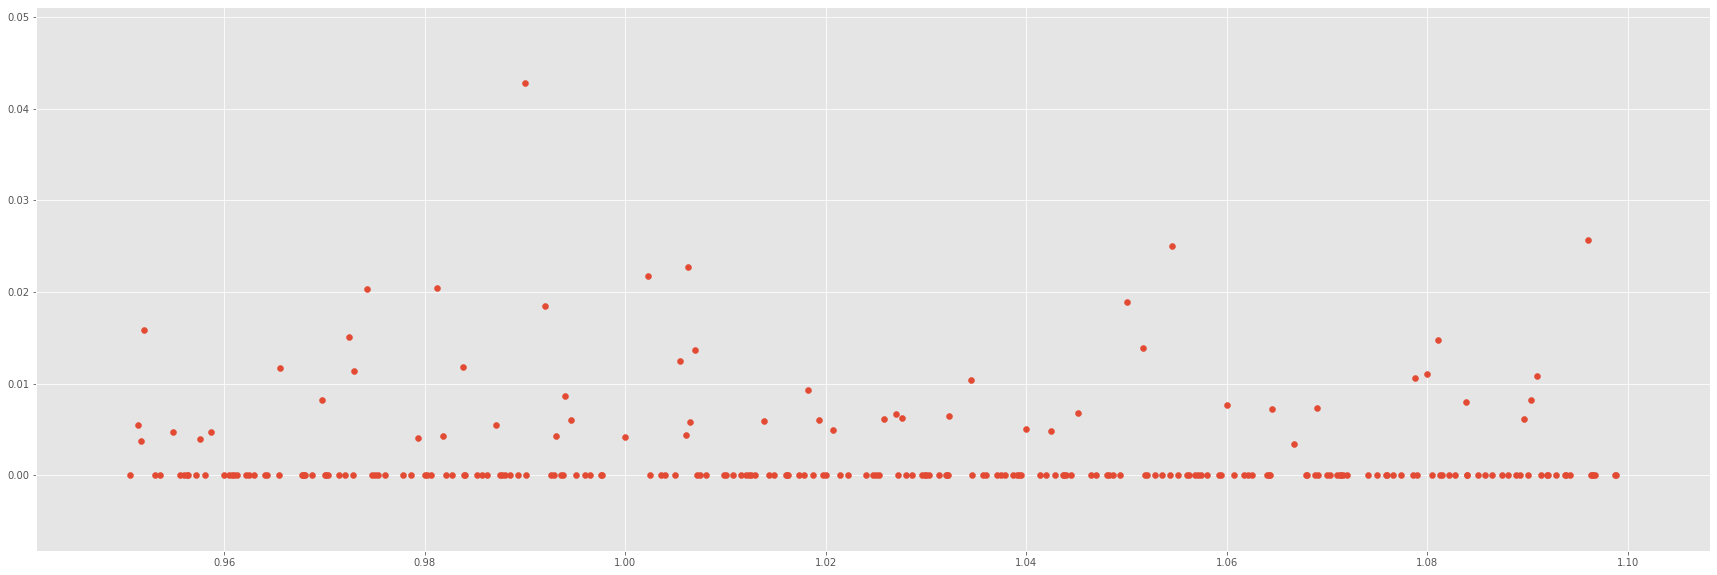

In [50]:
fig, ax = plt.subplots(figsize=(30,10))
ax.scatter(df_percent_near_bin.percent_near_bin, df_percent_near_bin.is_winner)

In [20]:
df["percent_near_bin"] = df["bids_so_far0"]/(df["cashvalue"]*2.5)

In [24]:
df.percent_near_bin

0         0.012121
1         0.048485
2         0.024242
3         0.012121
4         0.060606
            ...   
551421    0.084848
551422    0.048485
551423    0.036364
551424    0.024242
551425    0.024242
Name: percent_near_bin, Length: 551426, dtype: float64

(array([2.8052e+04, 2.3974e+04, 1.7398e+04, 1.1715e+04, 8.6520e+03,
        6.6990e+03, 4.9320e+03, 3.6060e+03, 2.7550e+03, 2.2980e+03,
        1.7060e+03, 1.4050e+03, 1.1090e+03, 9.6400e+02, 7.7300e+02,
        6.7600e+02, 5.2400e+02, 4.5300e+02, 3.7200e+02, 3.3300e+02,
        3.3200e+02, 2.7400e+02, 2.1700e+02, 1.7800e+02, 1.4600e+02,
        1.1200e+02, 1.0200e+02, 9.0000e+01, 7.9000e+01, 5.7000e+01,
        4.4000e+01, 3.4000e+01, 3.0000e+01, 2.9000e+01, 2.5000e+01,
        2.8000e+01, 2.5000e+01, 2.6000e+01, 1.7000e+01, 1.7000e+01,
        1.6000e+01, 1.7000e+01, 1.8000e+01, 1.6000e+01, 1.7000e+01,
        1.6000e+01, 1.7000e+01, 9.0000e+00, 9.0000e+00, 1.0000e+01]),
 array([0.70123457, 0.79260988, 0.88398519, 0.97536049, 1.0667358 ,
        1.15811111, 1.24948642, 1.34086173, 1.43223704, 1.52361235,
        1.61498765, 1.70636296, 1.79773827, 1.88911358, 1.98048889,
        2.0718642 , 2.16323951, 2.25461481, 2.34599012, 2.43736543,
        2.52874074, 2.62011605, 2.71149136, 2.

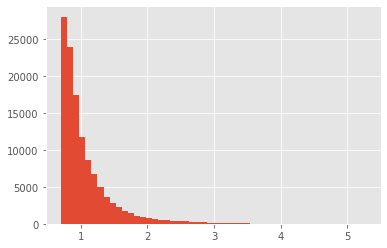

In [46]:
plt.hist(df.percent_near_bin[df.percent_near_bin > .70], bins=50)

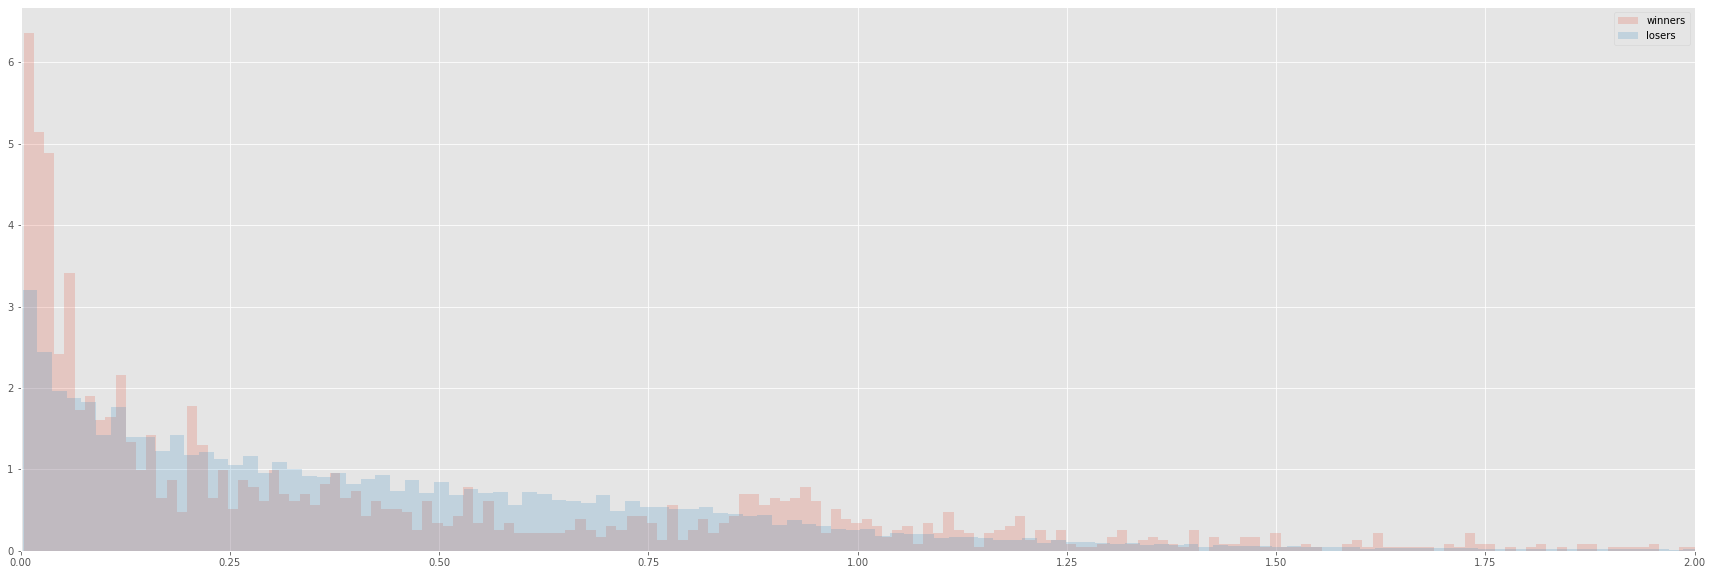

In [65]:
fig, ax = plt.subplots(figsize=(30,10))
ax.hist(df[df.is_winner==True].percent_near_bin, bins=300, alpha=.2, density=True, label="winners")
ax.hist(df[df.is_winner==False].percent_near_bin, bins=300, alpha = 0.2, density=True, label="losers")
ax.set_xlim(left=0, right=2)
ax.legend()

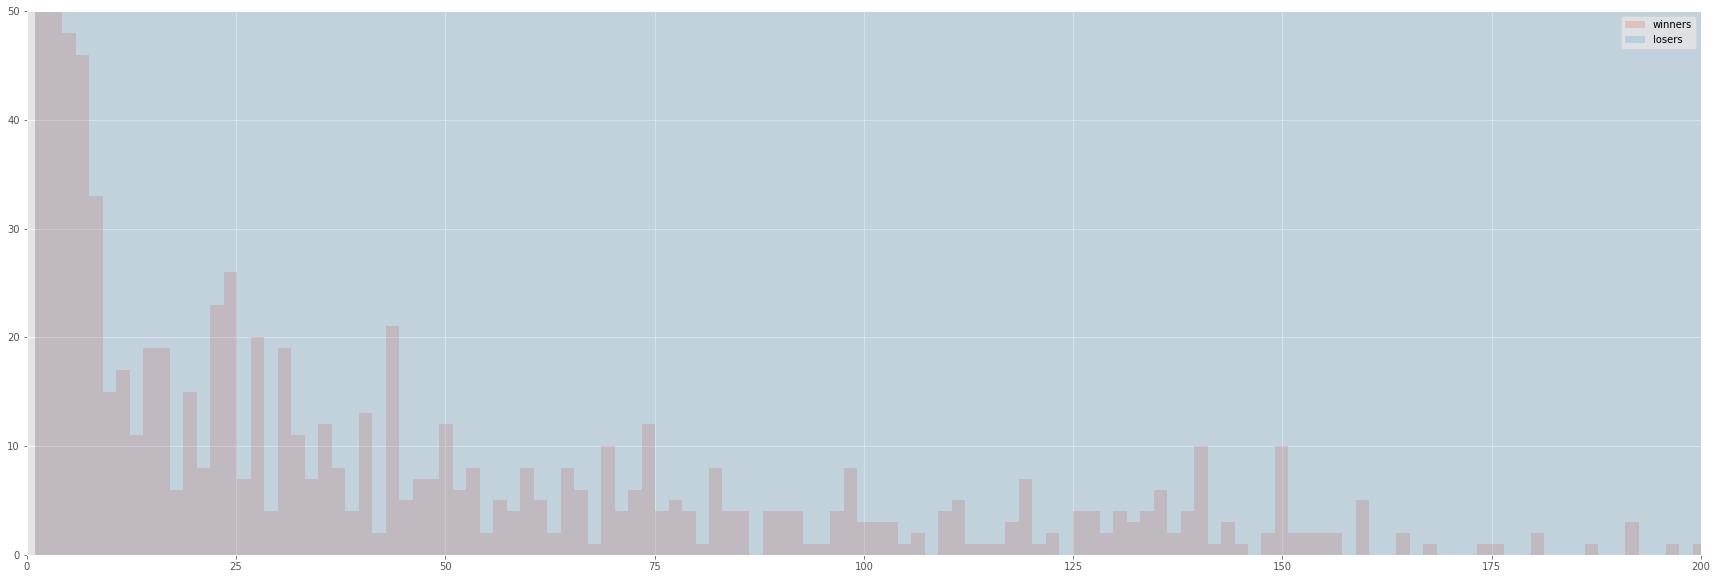

In [71]:
fig, ax = plt.subplots(figsize=(30,10))
ax.hist(df[(df.is_winner==True)&(df.is_bidomatic0==1)].streak0, bins=300, alpha=.2, label="winners")
ax.hist(df[(df.is_winner==False)&(df.is_bidomatic0==1)].streak0, bins=300, alpha = 0.2, label="losers")
ax.set_xlim(left=0, right=200)
ax.set_ylim(bottom=0, top=50)
ax.legend()

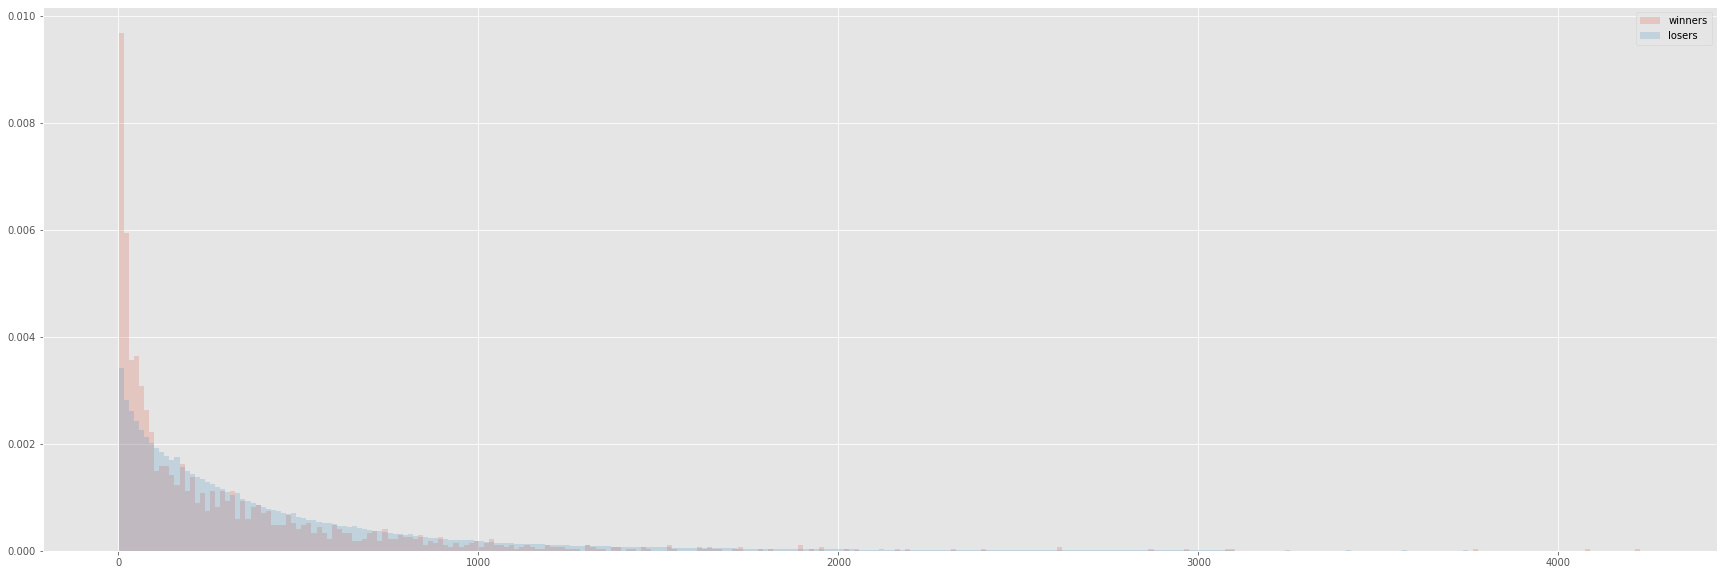

In [73]:
fig, ax = plt.subplots(figsize=(30,10))
ax.hist(df[df.is_winner==True].bid, bins=300, alpha=.2, density=True, label="winners")
ax.hist(df[df.is_winner==False].bid, bins=300, alpha = 0.2, density=True, label="losers")
#ax.set_xlim(left=0, right=2)
ax.legend()

In [87]:
df.groupby(["is_bidomatic0", "is_bidomatic1"]).mean()

auctionid  is_winner  cashvalue  cardvalue  \
is_bidomatic0 is_bidomatic1                                                  
False         False          5.447506e+08   0.010069  57.510569  36.490727   
              True           5.431648e+08   0.004306  63.798474  45.109412   
True          False          5.470516e+08   0.002190  67.494677  46.413925   
              True           5.370743e+08   0.001616  66.733254  49.182085   

                              bidvalue  limited_allowed  is_locked  \
is_bidomatic0 is_bidomatic1                                          
False         False          52.549603         0.327151   0.326531   
              True           46.722656         0.342564   0.273780   
True          False          52.701879         0.365762   0.319501   
              True           43.877920         0.339783   0.283811   

                                    bid  is_bidomatic  bids_so_far  ...  \
is_bidomatic0 is_bidomatic1                                         ...   
False         False          402.388524      0.665776    69.921445  ...   
              True           394.539784      0.671876    58.959056  ...   
True          False          461.038482      0.817996    79.099816  ...   
              True           419.572801      0.757769    62.504148  ...   

                               streak1  distance2  bids_so_far2  \
is_bidomatic0 is_bidomatic1                                       
False         False          12.570632  48.673812     42.120688   
              True           49.973700  40.304034     35.971677   
True          False           9.657926  56.845586     37.914334   
              True           50.425125  56.778389     30.888910   

                             bom_bids_so_far2    streak2  distance3  \
is_bidomatic0 is_bidomatic1                                           
False         False                 30.342039  24.584681  90.857702   
              True                  26.994852  22.389501  77.516475   
True          False                 28.361797  19.956656  98.557367   
              True                  23.334916  18.652087  99.027337   

                             bids_so_far3  bom_bids_so_far3    streak3  \
is_bidomatic0 is_bidomatic1                                              
False         False             36.721847         27.016101  21.625656   
              True              32.384469         24.696456  18.588917   
True          False             39.086254         29.820094  22.046329   
              True              32.501783         25.914767  18.462706   

                             percent_near_bin  
is_bidomatic0 is_bidomatic1                    
False         False                  0.401769  
              True                   0.275530  
True          False                  0.502850  
              True                   0.437653  

[4 rows x 28 columns]